# ChessBot Research Project Playground
here is where we can play against the bot (for now against ourself)

In [1]:
import chess
import chess.svg
import chess.engine
from IPython.display import display, clear_output
import random
from time import sleep

In [90]:
def is_game_finished(board: chess.Board) -> bool:
    if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_variant_draw():
        outcome = board.outcome()
        if outcome.winner == 1:
            print(f"Game finished: white wins by {str(outcome.termination)[12:].lower()}")
        elif outcome.winner == 0:
            print(f"Game finished: black wins by {str(outcome.termination)[12:].lower()}")
        else:
            print(f"Game finished: {str(outcome.termination)[12:].lower()}")
        return True
    return False

def check_move(board, move):
    uci_move = board.parse_san(move)

    if not uci_move in board.legal_moves: raise ValueError("illegal move")

    return uci_move

def show_board(board, uci_move, size=500):
    # make the move
    board.push(uci_move)
    clear_output(wait=True)
    display(chess.svg.board(board=board, size=size))
    return board

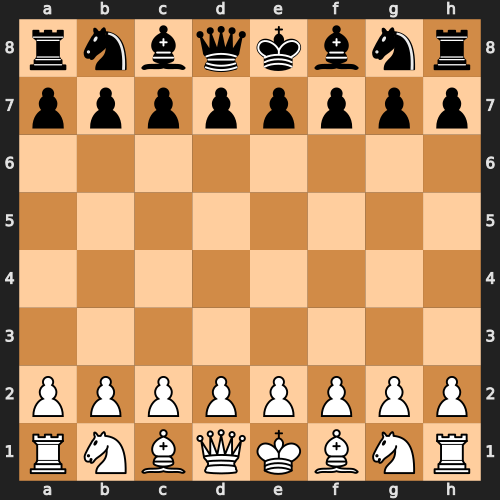

In [4]:
board = chess.Board()
display(chess.svg.board(board=board, size=500))
while is_game_finished(board) == False:
    move = str(input("Enter your move: "))
    if move == "quit" or move == "exit" or move == "stop":
        break
    try:
        uci_move = check_move(board, move)
        board = show_board(board, uci_move)
    except ValueError as e:
        print(e)

In [107]:
PAWN = 100
KNIGHT = 300
BISHOP = 300
ROOK = 500
QUEEN = 900
KING = 1000000

def evaluate_position(board):

    if board.is_checkmate():
        if board.turn == chess.WHITE:
            return -10000
        else:
            return 10000

    if board.is_stalemate():
        if board.turn == chess.WHITE:
            return 10000
        else:
            return -10000

    material_score = 0
    checkscore = 0
    castlescore = 0
    for piece in board.piece_map().values():
        if piece.color == chess.WHITE:
            if piece.piece_type == chess.PAWN:
                material_score += PAWN
            elif piece.piece_type == chess.KNIGHT:
                material_score += KNIGHT
            elif piece.piece_type == chess.BISHOP:
                material_score += BISHOP
            elif piece.piece_type == chess.ROOK:
                material_score += ROOK
            elif piece.piece_type == chess.QUEEN:
                material_score += QUEEN
            elif piece.piece_type == chess.KING:
                material_score += KING
        else:
            if piece.piece_type == chess.PAWN:
                material_score -= PAWN
            elif piece.piece_type == chess.KNIGHT:
                material_score -= KNIGHT
            elif piece.piece_type == chess.BISHOP:
                material_score -= BISHOP
            elif piece.piece_type == chess.ROOK:
                material_score -= ROOK
            elif piece.piece_type == chess.QUEEN:
                material_score -= QUEEN
            elif piece.piece_type == chess.KING:
                material_score -= KING

    if board.is_check():
        if board.turn == chess.WHITE:
            checkscore = -20
        else:
            checkscore = 20

    white_mobility = len(list(board.legal_moves))
    # Save current state of the board
    board_copy = board.copy()
    # Flip the board so that black is to move
    board_copy.turn = chess.BLACK
    # Calculate legal moves for black
    black_mobility = len(list(board_copy.legal_moves))
    # Average mobility of both sides
    mobility_score = (white_mobility - black_mobility)

    score = material_score + mobility_score + checkscore + castlescore
    return score

In [278]:
def order_moves(board):
    legal_moves = list(board.legal_moves)
    def sort_moves(move, board):
        movescoregeuss = 0
        if board.gives_check(move):
            movescoregeuss += 1000
        try:
            if board.is_capture(move):
                captured_piece = board.piece_at(move.to_square)
                attacking_piece = board.piece_at(move.from_square)
                if not attacking_piece or not captured_piece:
                    return movescoregeuss
                if attacking_piece.piece_type < captured_piece.piece_type:
                    movescoregeuss += 20*(captured_piece.piece_type**2 - attacking_piece.piece_type**2)
                elif attacking_piece.piece_type > captured_piece.piece_type:
                    movescoregeuss += 10*(attacking_piece.piece_type**2 - captured_piece.piece_type**2)
                else:
                    movescoregeuss += 10
        except:
            pass
        if move.promotion is not None:
            movescoregeuss += 10
        return movescoregeuss
    legal_moves.sort(key=lambda move: sort_moves(move, board), reverse=True)
    return legal_moves

def minimax(board, depth, alpha, beta, maximizingPlayer, verbose):
    if depth == 0 or board.is_game_over():
        if maximizingPlayer:
            return evaluate_position(board) - depth
        else:
            return evaluate_position(board) + depth
    if maximizingPlayer:
        value = float("-inf")
        # for move in board.legal_moves:
        if verbose == 2: print(order_moves(board))
        for move in order_moves(board):
            board.push(move)
            if board.is_castling(move): print("castling")
            value = max(value, minimax(board, depth-1, alpha, beta, False, verbose))
            if verbose == 2: print(board.peek(), value)
            board.pop()
            alpha = max(alpha, value)
            if alpha >= beta:
                value = value - 1
                if verbose == 3: print("snip because" + str(alpha) + " >= " + str(beta))
                break # beta cut-off
        return value
    else:
        value = float("inf")
        # for move in board.legal_moves:
        if verbose == 2: print(order_moves(board))
        for move in order_moves(board):
            board.push(move)
            if board.is_castling(move): print("castling")
            value = min(value, minimax(board, depth-1, alpha, beta, True, verbose))
            if verbose == 2: print(board.peek(), value)
            board.pop()
            beta = min(beta, value)
            if alpha >= beta:
                value = value - 1
                if verbose == 3: print("snip because" + str(alpha) + " >= " + str(beta))
                break # alpha cut-off
    return value


def get_best_move(board, depth=1, maximizingPlayer=True, verbose=0):
    bestMove = None
    if maximizingPlayer:
        bestValue = float("-inf")
    else:
        bestValue = float("inf")
    alpha = float("-inf")
    beta = float("inf")
    arr=[]
    # for move in board.legal_moves:
    for move in order_moves(board):
        board.push(move)
        moveValue = minimax(board, depth-1, alpha, beta, not maximizingPlayer, verbose)
        if verbose == 2 or verbose == 3:
            print(f"move: {move} value: {moveValue}      deeper moves ^^^")
        board.pop()
        arr.append([move,moveValue])
        if maximizingPlayer:
            if moveValue > bestValue:
                bestValue = moveValue
                bestMove = move
                alpha = max(alpha, bestValue)
            if alpha >= beta:
                if verbose == 3: print("snip because" + str(alpha) + " >= " + str(beta))
                break
        else:
            if moveValue < bestValue:
                bestValue = moveValue
                bestMove = move
                beta = min(beta, bestValue)
            if alpha >= beta:
                if verbose == 3: print("snip because" + str(alpha) + " >= " + str(beta))
                break
        # this is to avoid the computer always choosing the same move when there are multiple moves with the same value
        if moveValue == bestValue and random.randint(1, 10) == 1:
            bestMove = move
    
    if verbose == 1 or verbose == 3:
        for item in arr:
            print(item[0],item[1])
            
    return bestMove

# me vs bot

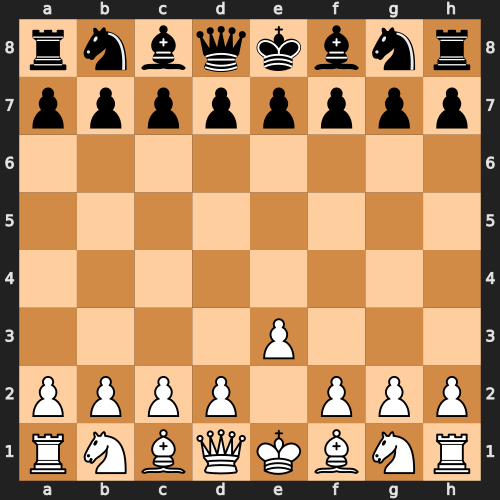

In [217]:
bot_black = False

board = chess.Board()
display(chess.svg.board(board=board, size=500))
while is_game_finished(board) == False:
    try:
        if bot_black:
            move = str(input("Enter your move: "))
            if move == "quit" or move == "exit" or move == "stop": break
            uci_move = check_move(board, move)
            board = show_board(board, uci_move)
        if is_game_finished(board): break

        best_move = get_best_move(board, depth=2, maximizingPlayer=board.turn)
        board = show_board(board, best_move)

        bot_black = True
    except ValueError as e:
        print(e)

# bot vs bot

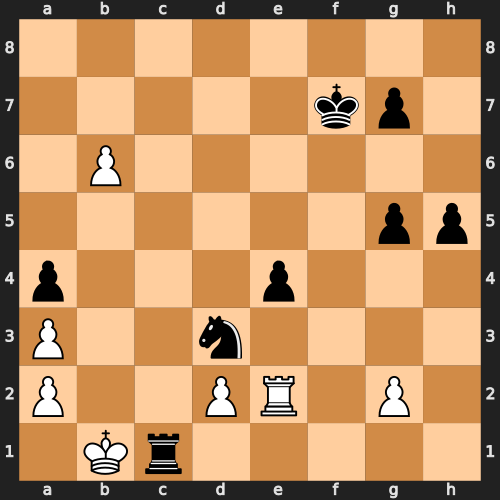

Game finished: black wins by checkmate


In [273]:
import time

board = chess.Board()
display(chess.svg.board(board=board, size=500))
while is_game_finished(board) == False:
    try:
        best_move = get_best_move(board, depth=3, maximizingPlayer=board.turn)
        board = show_board(board, best_move)
    except ValueError as e:
        print(e)

# bot vs position

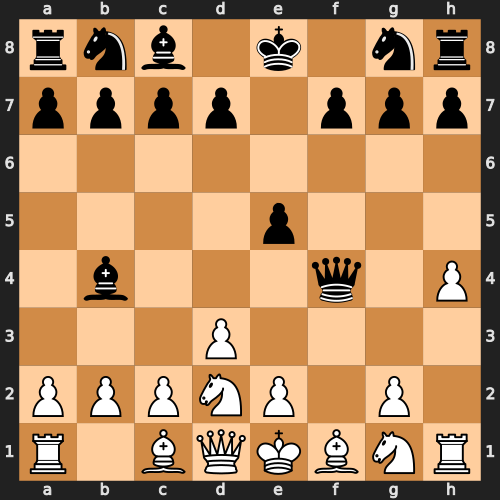

h1h3 -inf
h1h2 -inf
g1h3 -inf
g1f3 -10003
a1b1 -inf
h4h5 -inf
d3d4 -10004
g2g3 -10004
e2e3 -447
c2c3 -10004
b2b3 -710
a2a3 -709
g2g4 -inf
e2e4 -10003
c2c4 -449
a2a4 -449
e2e3


In [279]:
# board = chess.Board("r3k2r/p1ppqpb1/bn2pnp1/3PN3/1p2P3/2N2Q1p/PPPBBPPP/R3K2R w - - 0 1")
board = chess.Board("rnb1k1nr/pppp1ppp/8/4p3/1b3q1P/3P4/PPPNP1P1/R1BQKBNR w KQkq - 0 5")
# board.push_san("a2a3")
display(chess.svg.board(board=board, size=500))

best_move = get_best_move(board, depth=5, maximizingPlayer=board.turn, verbose=1)
print(best_move)

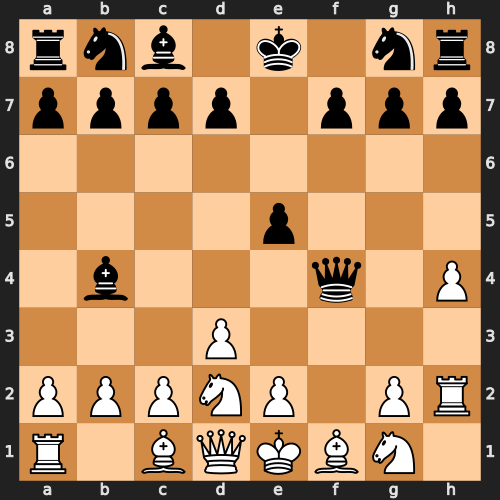

-100
h2h4 700 700
g2g3 -200 700
move: f4h4 value: 700 deeper moves ^^^
c1d2 500 500
d1d2 500 500
e1f2 -400 500
move: f4d2 value: 500 deeper moves ^^^
e1f1 500 500
move: f4f1 value: 500 deeper moves ^^^
d1d2 -100 -100
c1d2 -100 -100
move: b4d2 value: -100 deeper moves ^^^
move: f4g3 value: -10001 deeper moves ^^^
e1f2 800 800
move: f4f2 value: 800 deeper moves ^^^
g1h3 -600 -600
g1f3 -600 -600
e1f2 -600 -600
a1b1 -600 -600
h4h5 -600 -600
d3d4 -600 -600
g2g3 -600 -600
e2e3 -600 -600
c2c3 -600 -600
b2b3 -600 -600
a2a3 -600 -600
g2g4 -600 -600
e2e4 -600 -600
c2c4 -600 -600
a2a4 -600 -600
move: f4h2 value: -600 deeper moves ^^^
h2h3 -100 -100
h2h1 -100 -100
g1h3 -100 -100
g1f3 -100 -100
a1b1 -100 -100
h4h5 -100 -100
d3d4 -100 -100
g2g3 -100 -100
e2e3 -100 -100
c2c3 -100 -100
b2b3 -100 -100
a2a3 -100 -100
g2g4 -100 -100
e2e4 -100 -100
c2c4 -100 -100
a2a4 -100 -100
move: g8e7 value: -100 deeper moves ^^^
h2h3 -100 -100
h2h1 -100 -100
g1h3 -100 -100
g1f3 -100 -100
a1b1 -100 -100
h4h5 -100 -100

In [156]:
board = chess.Board("rnb1k1nr/pppp1ppp/8/4p3/1b3q1P/3P4/PPPNP1P1/R1BQKBNR w KQkq - 0 5")
board.push_san("h1h2")
display(chess.svg.board(board=board, size=500))

print(evaluate_position(board))

best_move = get_best_move(board, depth=2, maximizingPlayer=board.turn, verbose=2)
print(best_move)

# get full game

In [274]:
# for move  d7e5  the value is  -297
# f5g4

import chess.pgn

game = chess.pgn.Game.from_board(board)

# Set the headers for the game
game.headers["Event"] = "bot Game"
game.headers["Site"] = "offline vscode"
game.headers["Date"] = time.strftime("%Y.%m.%d")
game.headers["Round"] = "1"
game.headers["White"] = "bot"
game.headers["Black"] = "bot"
game.headers["Result"] = board.result()

print(game)

[Event "bot Game"]
[Site "offline vscode"]
[Date "2023.01.17"]
[Round "1"]
[White "bot"]
[Black "bot"]
[Result "0-1"]

1. Nh3 d5 2. Ng5 Bg4 3. Rg1 e5 4. h4 Bb4 5. Rh1 Qf6 6. Rh2 Qf4 7. Rh1 Bc5 8. e3 Qxg5 9. Bb5+ c6 10. Bxc6+ Nxc6 11. hxg5 Bxd1 12. Kxd1 b5 13. Rh5 Nb4 14. Rh4 Bf8 15. g6 fxg6 16. Rg4 a5 17. Rg5 Bd6 18. c3 Nd3 19. Kc2 Be7 20. Rg4 e4 21. Rg3 Rc8 22. Rg4 Kf7 23. Rg3 Nh6 24. Rh3 Ng4 25. Rg3 Ngxf2 26. Na3 Bh4 27. Rh3 d4 28. Rxh4 g5 29. Rh5 Kg6 30. Rh2 Ng4 31. Rh3 Ngf2 32. Rg3 dxe3 33. Rxe3 b4 34. Rg3 bxa3 35. bxa3 Rb8 36. Re3 Kf7 37. Re2 Rb6 38. c4 Rd8 39. c5 h5 40. cxb6 Rc8+ 41. Kb3 Nxc1+ 42. Rxc1 a4+ 43. Kb2 Nd3+ 44. Kb1 Rxc1# 0-1
